
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    qs = tf.sigmoid(Qs) # qt
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss

In [10]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # Bellman equaion: Qs = rt/qt + nextQs_G/D
    qs = tf.sigmoid(Qs) # qt
    targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    return d_loss

In [12]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    # targetQs_D = qs + (gamma * nextQs_D)
    # targetQs_G = targetQs_D
    # nextQs_G = nextQs_D 
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [13]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return q_opt, g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [18]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(prev_actions.shape, states.shape, actions.shape, next_states.shape, dones.shape, dones.dtype)
            #print(dones[:3])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # D(At-1, St)= Qs and qs = tf.sigmoid(Qs)
            # NextQs/Qt+1 are given both:
            # targetQs = qs + gamma * nextQs_G
            # targetQs = qs + gamma * nextQs_D
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
#             q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 20.0 Training q_loss: 0.0000 Training g_loss: 0.0032 Training d_loss: 0.2773 Explore P: 0.9980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0109 Training d_loss: 0.3990 Explore P: 0.9968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 1.5698 Training d_loss: 3.5760 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 28.0 Training q_loss: 0.0000 Training g_loss: 0.0477 Tr

-------------------------------------------------------------------------------
Episode: 31 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0434 Training d_loss: 19.3282 Explore P: 0.9425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 37.0 Training q_loss: 0.0000 Training g_loss: 0.0023 Training d_loss: 13.5679 Explore P: 0.9391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 29.0 Training q_loss: 0.0000 Training g_loss: 0.0050 Training d_loss: 6.0503 Explore P: 0.9364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 17.0 Training q_loss: 0.0000 Training g_loss: 0.0

-------------------------------------------------------------------------------
Episode: 61 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0086 Training d_loss: 14.9913 Explore P: 0.8928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 20.0 Training q_loss: 0.0000 Training g_loss: 0.0113 Training d_loss: 11.0324 Explore P: 0.8910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 20.0 Training q_loss: 0.0000 Training g_loss: 0.0493 Training d_loss: 9.3425 Explore P: 0.8893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0

-------------------------------------------------------------------------------
Episode: 91 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 0.0435 Training d_loss: 15.0143 Explore P: 0.8427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0012 Training d_loss: 11.7413 Explore P: 0.8414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0166 Training d_loss: 13.5922 Explore P: 0.8405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 121 Total reward: 39.0 Training q_loss: 0.0000 Training g_loss: 0.0196 Training d_loss: 11.9188 Explore P: 0.7919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0141 Training d_loss: 8.4769 Explore P: 0.7908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0116 Training d_loss: 14.7949 Explore P: 0.7899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 150 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 0.0625 Training d_loss: 11.4612 Explore P: 0.7511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0235 Training d_loss: 10.5729 Explore P: 0.7501
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.1642 Training d_loss: 15.6245 Explore P: 0.7495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 153 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 179 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0094 Training d_loss: 12.7867 Explore P: 0.7141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 30.0 Training q_loss: 0.0000 Training g_loss: 0.0689 Training d_loss: 13.3663 Explore P: 0.7120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 19.0 Training q_loss: 0.0000 Training g_loss: 0.0162 Training d_loss: 8.1753 Explore P: 0.7106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 210 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 0.0064 Training d_loss: 10.6550 Explore P: 0.6771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0062 Training d_loss: 17.3943 Explore P: 0.6761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0161 Training d_loss: 15.4962 Explore P: 0.6752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss

-------------------------------------------------------------------------------
Episode: 239 Total reward: 20.0 Training q_loss: 0.0000 Training g_loss: 0.0095 Training d_loss: 9.8863 Explore P: 0.6479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 17.0 Training q_loss: 0.0000 Training g_loss: 0.0019 Training d_loss: 12.5264 Explore P: 0.6468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 0.0003 Training d_loss: 11.4441 Explore P: 0.6454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 269 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0644 Training d_loss: 12.9649 Explore P: 0.6194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 30.0 Training q_loss: 0.0000 Training g_loss: 0.0498 Training d_loss: 15.7573 Explore P: 0.6176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 271 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0023 Training d_loss: 9.2652 Explore P: 0.6167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 298 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.1716 Training d_loss: 10.5293 Explore P: 0.5917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.1168 Training d_loss: 9.3003 Explore P: 0.5909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0304 Training d_loss: 14.3030 Explore P: 0.5900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 328 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0199 Training d_loss: 10.0955 Explore P: 0.5684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.2008 Training d_loss: 9.4223 Explore P: 0.5677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.3228 Training d_loss: 14.5902 Explore P: 0.5671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 358 Total reward: 22.0 Training q_loss: 0.0000 Training g_loss: 0.0040 Training d_loss: 11.1281 Explore P: 0.5444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 359 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0035 Training d_loss: 8.3533 Explore P: 0.5439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 360 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0018 Training d_loss: 12.9966 Explore P: 0.5430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 23.0 Training q_loss: 0.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 388 Total reward: 30.0 Training q_loss: 0.0000 Training g_loss: 0.0009 Training d_loss: 15.5451 Explore P: 0.5216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 17.0 Training q_loss: 0.0000 Training g_loss: 0.1279 Training d_loss: 11.4515 Explore P: 0.5208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 390 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0112 Training d_loss: 7.6809 Explore P: 0.5202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 391 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 417 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0252 Training d_loss: 17.9959 Explore P: 0.5004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0127 Training d_loss: 14.6598 Explore P: 0.4998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0011 Training d_loss: 12.0692 Explore P: 0.4992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 420 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss

-------------------------------------------------------------------------------
Episode: 447 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0033 Training d_loss: 11.8155 Explore P: 0.4823
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0088 Training d_loss: 7.5112 Explore P: 0.4819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 17.0 Training q_loss: 0.0000 Training g_loss: 0.0087 Training d_loss: 16.3690 Explore P: 0.4811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 477 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0058 Training d_loss: 11.7178 Explore P: 0.4659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0088 Training d_loss: 11.1567 Explore P: 0.4651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 479 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0073 Training d_loss: 13.5541 Explore P: 0.4645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 480 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 508 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0101 Training d_loss: 9.2635 Explore P: 0.4482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0025 Training d_loss: 9.0333 Explore P: 0.4475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0153 Training d_loss: 11.5718 Explore P: 0.4472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 539 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.1522 Training d_loss: 10.8284 Explore P: 0.4312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0191 Training d_loss: 11.7659 Explore P: 0.4308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0694 Training d_loss: 11.2005 Explore P: 0.4304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 29.0 Training q_loss: 0.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 570 Total reward: 23.0 Training q_loss: 0.0000 Training g_loss: 0.0800 Training d_loss: 9.5179 Explore P: 0.4117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 571 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0580 Training d_loss: 12.2708 Explore P: 0.4112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 572 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0599 Training d_loss: 5.8009 Explore P: 0.4107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 573 Total reward: 22.0 Training q_loss: 0.0000 Training g_loss: 

Episode: 599 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0005 Training d_loss: 8.4276 Explore P: 0.3971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0024 Training d_loss: 12.6445 Explore P: 0.3967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0057 Training d_loss: 16.0507 Explore P: 0.3963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0184 Training d_loss: 12.2917 Explore P: 0.3959
-----------------------------

-------------------------------------------------------------------------------
Episode: 629 Total reward: 21.0 Training q_loss: 0.0000 Training g_loss: 0.0106 Training d_loss: 8.9793 Explore P: 0.3830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 630 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0183 Training d_loss: 11.4017 Explore P: 0.3825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 631 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0026 Training d_loss: 15.8519 Explore P: 0.3822
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 632 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 660 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0092 Training d_loss: 14.8654 Explore P: 0.3683
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 25.0 Training q_loss: 0.0000 Training g_loss: 0.0015 Training d_loss: 9.8418 Explore P: 0.3674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 662 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0139 Training d_loss: 9.5812 Explore P: 0.3671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 663 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 691 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0725 Training d_loss: 15.9759 Explore P: 0.3551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 18.0 Training q_loss: 0.0000 Training g_loss: 0.0093 Training d_loss: 15.4436 Explore P: 0.3545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0122 Training d_loss: 10.5985 Explore P: 0.3540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 721 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0020 Training d_loss: 12.8022 Explore P: 0.3424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 15.0 Training q_loss: 0.0000 Training g_loss: 0.0009 Training d_loss: 11.3600 Explore P: 0.3419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 723 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0001 Training d_loss: 8.3270 Explore P: 0.3415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 751 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0000 Training d_loss: 13.3149 Explore P: 0.3303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0030 Training d_loss: 10.4014 Explore P: 0.3300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0016 Training d_loss: 14.9964 Explore P: 0.3297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 781 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0011 Training d_loss: 7.2332 Explore P: 0.3200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 782 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0000 Training d_loss: 12.6822 Explore P: 0.3197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 783 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0000 Training d_loss: 10.6639 Explore P: 0.3195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 811 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 0.0084 Training d_loss: 11.2483 Explore P: 0.3103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 812 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0009 Training d_loss: 12.5307 Explore P: 0.3099
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 813 Total reward: 12.0 Training q_loss: 0.0000 Training g_loss: 0.0009 Training d_loss: 10.8406 Explore P: 0.3096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 814 Total reward: 9.0 Training q_loss: 0.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 841 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0093 Training d_loss: 9.7283 Explore P: 0.3004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 842 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0420 Training d_loss: 7.4338 Explore P: 0.3001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 843 Total reward: 22.0 Training q_loss: 0.0000 Training g_loss: 0.0005 Training d_loss: 8.1646 Explore P: 0.2994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 844 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 871 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0159 Training d_loss: 14.3356 Explore P: 0.2904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 872 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0156 Training d_loss: 6.4829 Explore P: 0.2900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss: 0.0146 Training d_loss: 10.5151 Explore P: 0.2896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 874 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 902 Total reward: 14.0 Training q_loss: 0.0000 Training g_loss: 0.0146 Training d_loss: 10.4638 Explore P: 0.2803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0101 Training d_loss: 11.0444 Explore P: 0.2800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0002 Training d_loss: 8.8197 Explore P: 0.2798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 933 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0005 Training d_loss: 13.1722 Explore P: 0.2709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 7.0 Training q_loss: 0.0000 Training g_loss: 0.0001 Training d_loss: 8.3564 Explore P: 0.2707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0002 Training d_loss: 9.0785 Explore P: 0.2704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 963 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0024 Training d_loss: 11.0159 Explore P: 0.2625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 8.0 Training q_loss: 0.0000 Training g_loss: 0.0037 Training d_loss: 11.4691 Explore P: 0.2623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 965 Total reward: 11.0 Training q_loss: 0.0000 Training g_loss: 0.0043 Training d_loss: 10.8283 Explore P: 0.2621
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 13.0 Training q_loss: 0.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 993 Total reward: 16.0 Training q_loss: 0.0000 Training g_loss: 0.0003 Training d_loss: 10.9790 Explore P: 0.2542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 0.0045 Training d_loss: 9.8690 Explore P: 0.2540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 29.0 Training q_loss: 0.0000 Training g_loss: 0.0166 Training d_loss: 5.6235 Explore P: 0.2533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 10.0 Training q_loss: 0.0000 Training g_loss: 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

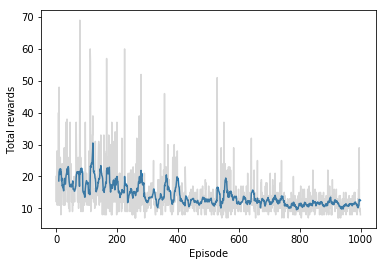

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

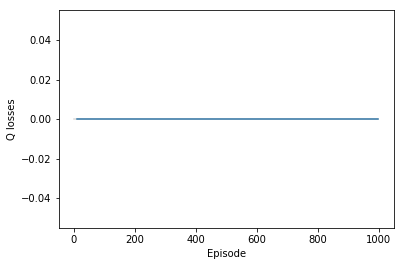

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

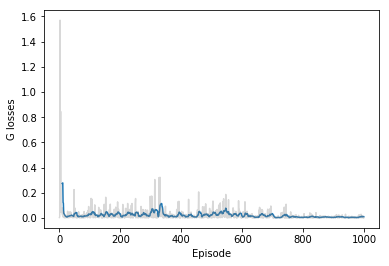

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

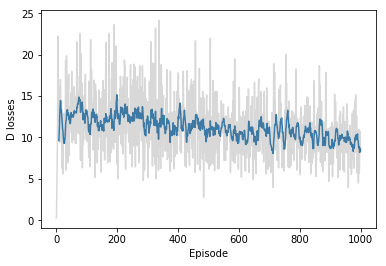

In [25]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [28]:
# # Closing the env
# # WARNING: If you close, you can NOT restart again!!!!!!
# env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.